# World Data League 2021


## External links and resources
Daily wheather data from Vancouver: https://vancouver.weatherstats.ca/download.html


## Introduction

In this stage, we will solve the challenge 2, identification of patterns and prediction of irregular parking, where the goal is to predict irregular parking at street level and day.

To solve this challenge we start by analysing the block level of the street where the infraction occurred to check which blocks had the most infractions. 
With the geospatial data we were able to map these blocks with more parking tickets and characterise these locations, showing possible reasons for such infractions.  

We believe that meteorological factors influence people's behaviour, which is why we have added external data on daily weather statistics from 2017 to 2019.

In addition, we add the length of the street, and this attribute has the most importance for the prediction.

In the prediction phase, we use gradient boosting for regression with hyperparameterisation grid and for evaluation we use the mean absolute error and mean squared error.

Our proposal for this problem proved to be efficient, as we were able to achieve acceptable results.


## Development

In [277]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import geopandas as gpd
import folium
import textwrap
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
parking_tickets = pd.read_csv('Stage2/parking-tickets-2017-2019_WDL.csv', sep=';')
parking_tickets.head()

,Unnamed: 0,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W


In [3]:
parking_tickets.shape

(1318735, 10)

In [4]:
parking_tickets.nunique()

Unnamed: 0        1318735
Block                 129
Street               1785
EntryDate            1089
Bylaw                   5
Section                98
Status                  5
InfractionText        123
Year                    3
HBLOCK              15219
dtype: int64

In [5]:
del parking_tickets[parking_tickets.columns[0]]

In [6]:
parking_tickets['EntryDate'].min()

'2017-01-02'

In [7]:
parking_tickets['EntryDate'].max()

'2019-12-31'

#### Add new attributes with date information

In [8]:
parking_tickets['EntryDate_DayofWeek'] = parking_tickets['EntryDate'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y-%m-%d').strftime('%a'))

In [9]:
parking_tickets['EntryDate_Week'] = parking_tickets['EntryDate'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y-%m-%d').strftime('%V'))

In [10]:
parking_tickets['EntryDate_Month'] = parking_tickets['EntryDate'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y-%m-%d').strftime('%b'))

In [11]:
# parking_tickets.head()

#### Which day of the week and month had the most parking tickets?

In [12]:
parking_tickets.sort_values(by='EntryDate', inplace=True)

In [13]:
week_days_block = parking_tickets.groupby(['EntryDate_DayofWeek', 'Block'], sort=False).size().reset_index(name='Count')
month_block = parking_tickets.groupby(['EntryDate_Month', 'Block'], sort=False).size().reset_index(name='Count')

In [14]:
cols = week_days_block['EntryDate_DayofWeek'].unique().tolist()
cols2 = month_block['EntryDate_Month'].unique().tolist()

In [15]:
piv_grouped = week_days_block.pivot(index='Block', columns='EntryDate_DayofWeek', values='Count').reindex(columns=cols)
piv_grouped2 = month_block.pivot(index='Block', columns='EntryDate_Month', values='Count').reindex(columns=cols2)

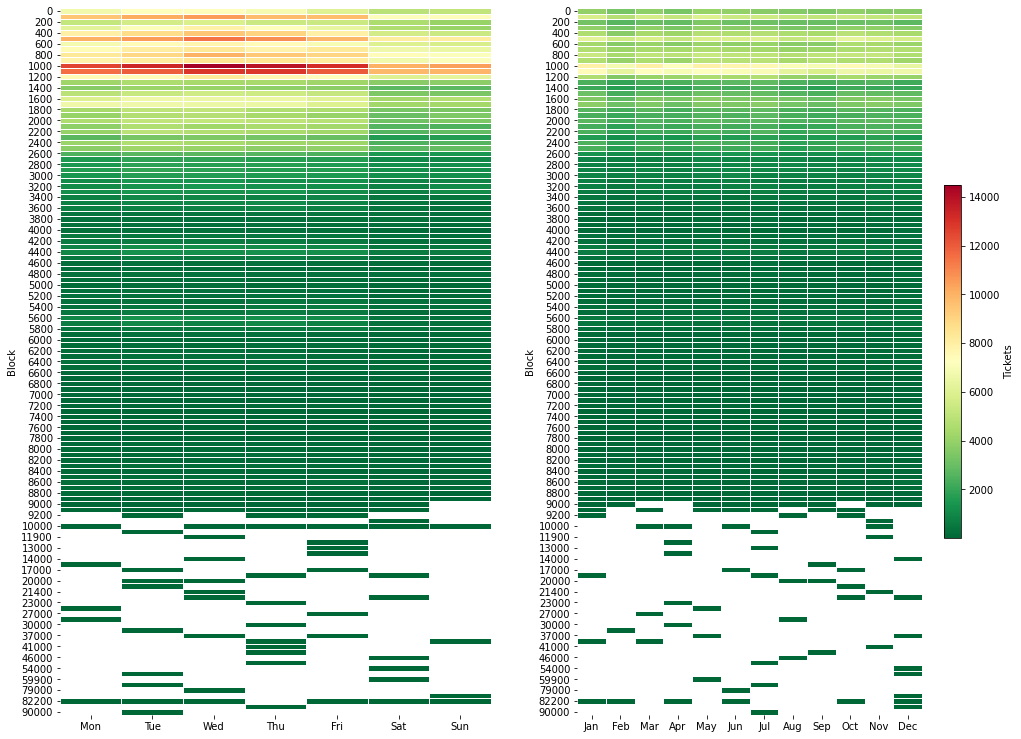

In [222]:
vmin = int(min(int(np.nanmin(piv_grouped.values)), int(np.nanmin(piv_grouped2.values))))
vmax = int(max(int(np.nanmax(piv_grouped.values)), int(np.nanmax(piv_grouped2.values))))
fig, axes = plt.subplots(ncols=2, figsize=(17, 13))
ax1, ax2 = axes
sns.heatmap(piv_grouped, cmap='RdYlGn_r', linewidths=0.5, vmin=vmin, ax=ax1, cbar=False)
sns.heatmap(piv_grouped2, cmap='RdYlGn_r', linewidths=0.5, vmax=vmax, ax=ax2, cbar=False)
im = plt.gca().get_children()[0]
fig.colorbar(im, shrink=.5, label='Tickets')
ax1.set(xlabel='')
ax2.set(xlabel='')
plt.ylabel('Block')
plt.title('')
plt.show()

On workdays, people tend to behave inappropriately resulting in more parking tickets.  However, there are no major differences in each month. 

#### In which areas of Vancouver are there more infractions?

From the previous figure we can see that up to block 2700 is where there are more infractions committed. So now let's see what are the possible reasons for this happening in such blocks. To do this, we first need to add the coordinates of the blocks.  

In [17]:
public_streets = gpd.read_file("Stage2/public-streets/public-streets.shp")

In [18]:
public_streets.head()

,hblock,streetuse,geometry
0,6300 INVERNESS ST,Residential,"LINESTRING (-123.08001 49.22657, -123.08003 49..."
1,1000 E 49TH AV,Secondary Arterial,"LINESTRING (-123.08456 49.22540, -123.08387 49..."
2,7700 JASPER CRESCENT,Residential,"LINESTRING (-123.06960 49.21384, -123.06943 49..."
3,8100-8200 BORDEN ST,Residential,"LINESTRING (-123.07395 49.21105, -123.07398 49..."
4,8400 ARGYLE ST,Residential,"LINESTRING (-123.07133 49.20868, -123.07134 49..."


In [20]:
public_streets.shape

(17033, 3)

In [165]:
def plot_gdf_folium(gdf):
    m = folium.Map((49.28242,-123.11627), zoom_start=12, tiles='OpenStreetMap')
    folium.GeoJson(gdf).add_to(m)
    return m

# plot_gdf_folium(public_streets)

#### Add length of each street

In [22]:
public_streets['street_length'] = public_streets['geometry'].to_crs({'init': 'epsg:4326'})\
               .map(lambda p: p.length)

/Users/taniacarvalho/Desktop/PyProjects/WDL2021/venv/lib/python3.9/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Text preprocessing in HBLOCK

To get the maximum matches between the two datasets, we need to apply some transformations to the 'hblock' attribute

In [27]:
hblock1 = parking_tickets.groupby(['HBLOCK']).size().reset_index(name='Count')
# pd.set_option('display.max_rows', 300)
# hblock1.tail(100)

In [28]:
hblock2 = public_streets.groupby(['hblock']).size().reset_index(name='Count')
# pd.set_option('display.max_rows', 300)
# hblock2.tail(10)

In [32]:
def hblock_preprocessing(df, colname):
    for i in range(0, len(df)):
        w = df[colname][i].split()

        # add "E" at the end of "AV"
        if 'AV' in w:
            pos_av = w.index('AV')
            w[pos_av] = 'AVE'
        
        # mantain the first number of zip code
        w1 = w[0].partition("-")[0]
        if w1 != '':
            w[0] = w1
        
        # update the hblock    
        up_words = ' '.join(w)    
        df.loc[i, colname] = up_words 
            
    return df        

In [37]:
parking_tickets['HBLOCK'] = parking_tickets['HBLOCK'].apply(lambda x: x.upper())
public_streets['hblock'] = public_streets['hblock'].apply(lambda x: x.upper())
public_streets = hblock_preprocessing(public_streets, 'hblock')

#### Removing duplicates in hblock from public streets data

In [39]:
public_streets_dups_rm = public_streets.drop_duplicates(subset='hblock')

In [45]:
public_streets_dups_rm.shape

(9487, 4)

#### Merge parking tickets and public streets by hblock

In [223]:
all_data = parking_tickets.merge(public_streets_dups_rm, left_on='HBLOCK', right_on='hblock', how='left')

In [224]:
del all_data['hblock']

In [225]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1318735 entries, 0 to 1318734
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   Block                1318735 non-null  int64   
 1   Street               1318735 non-null  object  
 2   EntryDate            1318735 non-null  object  
 3   Bylaw                1318735 non-null  int64   
 4   Section              1318735 non-null  object  
 5   Status               1318735 non-null  object  
 6   InfractionText       1318735 non-null  object  
 7   Year                 1318735 non-null  int64   
 8   HBLOCK               1318735 non-null  object  
 9   EntryDate_DayofWeek  1318735 non-null  object  
 10  EntryDate_Week       1318735 non-null  object  
 11  EntryDate_Month      1318735 non-null  object  
 12  streetuse            1073327 non-null  object  
 13  geometry             1073327 non-null  geometry
 14  street_length        1073327 non-n

#### Map the blocks where there is more parking tickets

First, the blocks that are coloured from light green to red on the heatmap (Block < 2800).

In [206]:
geom_tickets = all_data[all_data['Block'] < 2700]
geom_tickets = geom_tickets[['Block', 'HBLOCK', 'streetuse', 'street_length',  'geometry']]
geom_tickets = geom_tickets[pd.notnull(geom_tickets['geometry'])]
geom_tickets = geom_tickets.drop_duplicates('HBLOCK', keep="last")

In [173]:
len(geom_tickets)

4442

In [174]:
geom_tickets = gpd.GeoDataFrame(geom_tickets, crs="EPSG:4326", geometry=geom_tickets['geometry'])

In [175]:
plot_gdf_folium(geom_tickets)

In [211]:
length = geom_tickets.sort_values('street_length')
# length[['Block', 'street_length']].head(100)

The blocks presented here has many fire hydrants, as we can see in this [link!](https://opendata.vancouver.ca/explore/dataset/water-hydrants/map/?location=12,49.24921,-123.10799)

Also, the size of the street is smaller in this blocks. 

#### Add weather daily stats In Vancouver for the same period

In [226]:
weather = pd.read_csv('Stage2/weatherstats_vancouver_daily1.csv', sep=',')

In [227]:
# weather['date'] = weather['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
weather = weather.dropna(axis=1, how='all')
del weather['sunrise']
del weather['sunset']

In [228]:
all_data = all_data.merge(weather, left_on='EntryDate', right_on='date', how='left')

In [229]:
del all_data['date']

#### Target construction 

The target attribute is the number of infractions per street and day

In [230]:
all_data['target'] = all_data.groupby(['Street', 'EntryDate'])['Year'].transform('size')

In [231]:
all_data.shape

(1318735, 74)

In [232]:
# all_data['target'].unique()

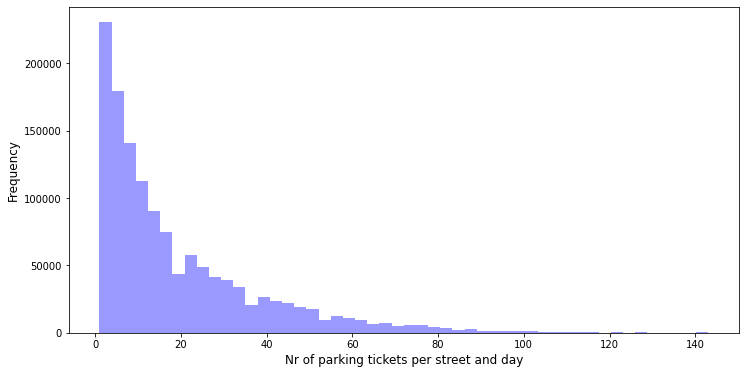

In [276]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.distplot(all_data['target'], hist=True, kde=False, color='blue')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Nr of parking tickets per street and day', fontsize=12)
plt.show()

#### How many times has a particular law been applied?

In [234]:
def change_width(ax, new_value) :
    locs = ax.get_xticks()
    for i,patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

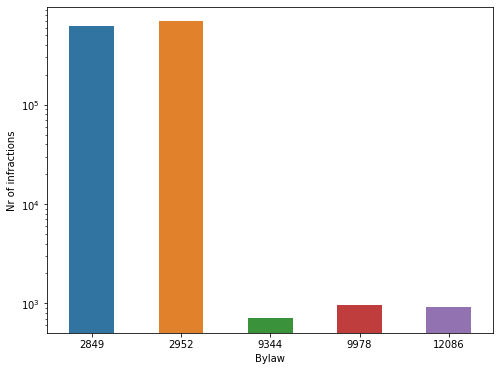

In [235]:
bylaw = all_data.groupby(['Bylaw']).size().reset_index(name='Count')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=bylaw, x="Bylaw", y="Count")
ax.set_yscale('log')
ax.set_xlabel('Bylaw', fontsize=10)
ax.set_ylabel('Nr of infractions', fontsize=10)
change_width(ax, .5)
plt.show()

The law applied most often to write a ticket was 2849 and 2952.

[2849](https://bylaws.vancouver.ca/2849c.pdf): traffic signs and signals; stopping and parking - streets and lanes; water on streets; snow clearing, ...

[2952](https://bylaws.vancouver.ca/2952c.PDF): meter rates.

#### In which status are there more parking tickets?

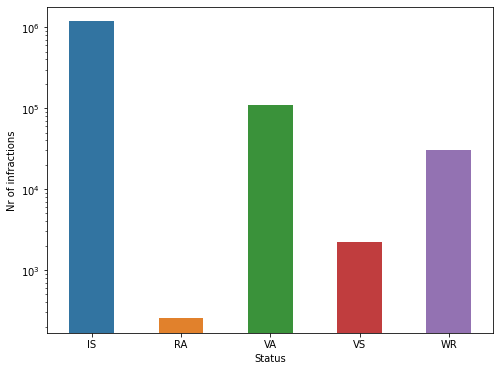

In [86]:
status = all_data.groupby(['Status']).size().reset_index(name='Count')
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=status, x="Status", y="Count")
ax.set_yscale('log')
ax.set_xlabel('Status', fontsize=10)
ax.set_ylabel('Nr of infractions', fontsize=10)
change_width(ax, .5)
plt.show()

Status of the parking ticket.
- IS = Issued
- RA = Cancelled due to Paid by Phone
- VA = Void
- VS = Auto-void
- WR = Warning

#### What is the difference in parking tickets per year?

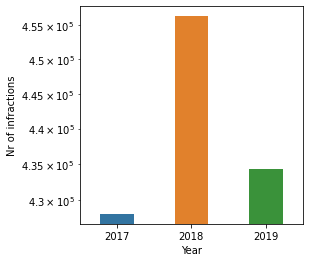

In [88]:
year = all_data.groupby(['Year']).size().reset_index(name='Count')
fig, ax = plt.subplots(figsize=(4, 4))
sns.barplot(data=year, x="Year", y="Count")
ax.set_yscale('log')
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Nr of infractions', fontsize=10)
change_width(ax, .45)
plt.show()

#### What is the influence of precipitation on parking tickets?

In [236]:
all_data['precipitation'].describe()

count    1.318735e+06
mean     3.267370e+00
std      6.961909e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.400000e+00
max      6.700000e+01
Name: precipitation, dtype: float64

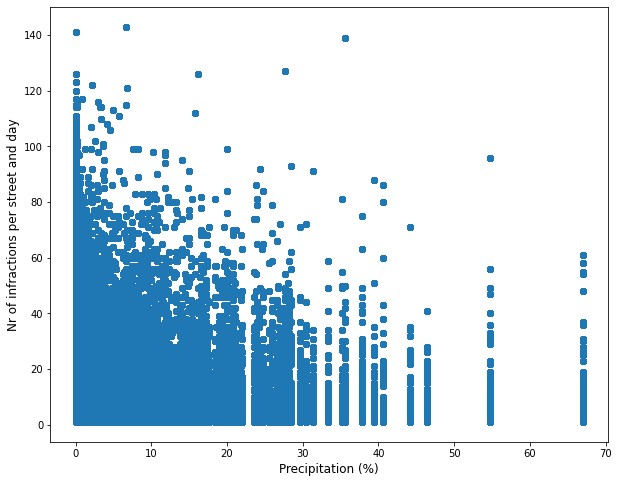

In [238]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(all_data['precipitation'], all_data['target'])
ax.set_xlabel('Precipitation (%)', fontsize=12)
ax.set_ylabel('Nr of infractions per street and day', fontsize=12)
plt.show()

On sunnier days people go out more, so there are more infractions recorded. 

#### Top 10 most occurred infractions

In [91]:
infractions_text = all_data[["Block", "InfractionText"]].copy()
infractions_text['lower_text'] = infractions_text['InfractionText'].str.lower()

In [92]:
infractions_text["text_wo_punct"] = infractions_text['lower_text'].str.rstrip('.')

In [93]:
inf = infractions_text.groupby(['text_wo_punct']).size().reset_index(name='Count')
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', 100)
# inf.head(100)

In [94]:
#inf.nlargest(10, 'Count')['text_wo_punct']
inf_top10 = inf.sort_values('Count', ascending=False).head(10)

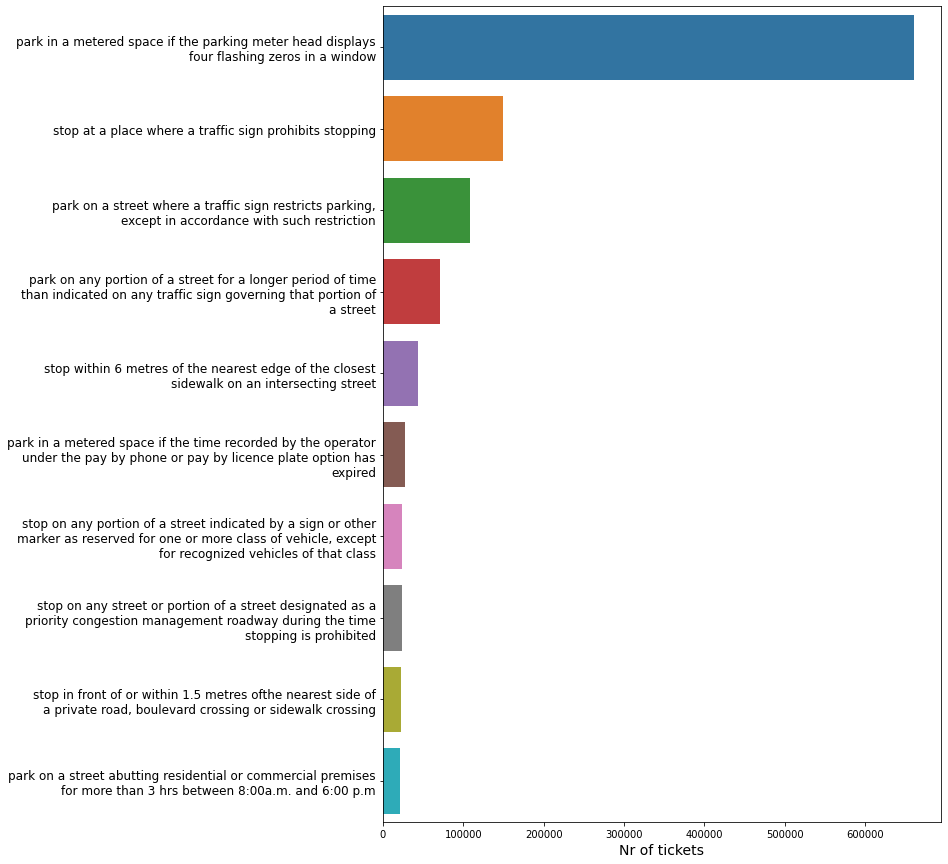

In [95]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.barplot(data=inf_top10, x="Count", y="text_wo_punct")
ax.set_yticklabels([textwrap.fill(e, 60) for e in inf_top10['text_wo_punct']], fontsize=12)
ax.set_xlabel('Nr of tickets', fontsize=14)
ax.set_ylabel('')
plt.show()

In [96]:
# all_data.to_csv('dataStage2.csv', index=False)

#### Delete high correlated attributes

In [98]:
# select the data for modeling
# data_mod = all_data.iloc[:, np.r_[0, 3, 5, 7, 9:13, 14:74]]
data_mod = all_data.iloc[:, np.r_[0, 3, 5, 7, 9:12, 14:19, 21:33, 35:59, 60:63, 65:74]]

In [101]:
# deal with categorical attributes
label_encoder = LabelEncoder()
data_mod.loc[:, 'Status'] = label_encoder.fit_transform(data_mod['Status'])
data_mod.loc[:, 'EntryDate_DayofWeek'] = label_encoder.fit_transform(data_mod['EntryDate_DayofWeek'])
data_mod.loc[:, 'EntryDate_Month'] = label_encoder.fit_transform(data_mod['EntryDate_Month'])
# data_mod.loc[:, 'streetuse'] = label_encoder.fit_transform(data_mod['streetuse'])
data_mod.loc[:, 'EntryDate_Week'] = data_mod['EntryDate_Week'].astype(int)

/Users/taniacarvalho/Desktop/PyProjects/WDL2021/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [102]:
# inputation of missing values with mean
data_mod = data_mod.apply(lambda x: x.fillna(x.mean())) 

In [239]:
# corr = data_mod.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [108]:
# create correlation matrix
corr_matrix = data_mod.corr().abs()

# upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop features 
data_mod.drop(to_drop, axis=1, inplace=True)

<ipython-input-108-90d71650610f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [110]:
data_mod.shape

(1318735, 32)

### Modeling

#### Select a sample to modeling

In [158]:
# 1318735 * 0.02
df = data_mod.sample(frac=0.05)

In [159]:
len(df)

65937

In [161]:
# split target from data
def prepare_modeling(df):
    data_mod_values = df.values
    X, y = data_mod_values[:, :-1], data_mod_values[:, -1]
    y = LabelEncoder().fit_transform(y)
    return X, y

In [162]:
def modeling(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

    xgb = GradientBoostingRegressor()

    # set parameters
    param_grid_xgb = {
        'n_estimators': [400, 500, 600],
        'max_depth': [8, 10]
    }

    # define metric functions
    scoring = {'mse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error'}

    # create the parameter grid
    gs_gbr = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring=scoring, refit='mae',
                          return_train_score=True, verbose=10)

    # Performing cross validation to tune parameters for best model fit
    gs_gbr.fit(X_train, y_train)
    
    return gs_gbr, X_test, y_test


In [163]:
X, y = prepare_modeling(df)
gs, X_test, y_test = modeling(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START max_depth=8, n_estimators=400...............................
[CV 1/5; 1/6] END max_depth=8, n_estimators=400; mae: (train=-4.720, test=-8.398) mse: (train=-49.211, test=-152.803) total time= 2.1min
[CV 2/5; 1/6] START max_depth=8, n_estimators=400...............................
[CV 2/5; 1/6] END max_depth=8, n_estimators=400; mae: (train=-4.727, test=-8.327) mse: (train=-48.768, test=-148.118) total time= 2.1min
[CV 3/5; 1/6] START max_depth=8, n_estimators=400...............................
[CV 3/5; 1/6] END max_depth=8, n_estimators=400; mae: (train=-4.686, test=-8.267) mse: (train=-48.359, test=-147.049) total time= 2.0min
[CV 4/5; 1/6] START max_depth=8, n_estimators=400...............................
[CV 4/5; 1/6] END max_depth=8, n_estimators=400; mae: (train=-4.715, test=-8.319) mse: (train=-48.491, test=-148.900) total time= 2.1min
[CV 5/5; 1/6] START max_depth=8, n_estimators=400...................

In [164]:
print('Best params: %s' % gs.best_params_)
print('Best score: %.3f' % gs.best_score_)
# results from grid search
res = {}
res['cv_results_'] = pd.DataFrame.from_dict(gs.cv_results_)
# predict on test data with best params
y_pred = gs.predict(X_test)

Best params: {'max_depth': 10, 'n_estimators': 400}
Best score: -8.275


In [254]:
# res['cv_results_'].columns

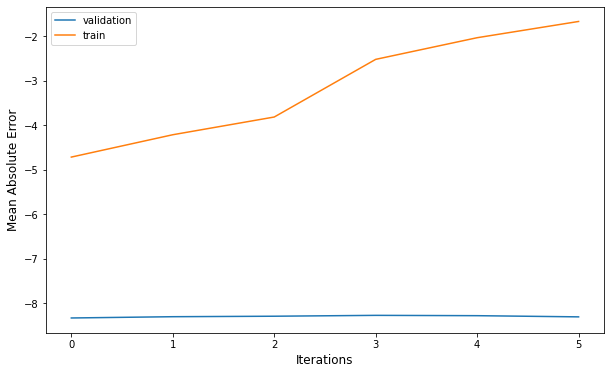

In [280]:
test_scores = res['cv_results_']['mean_test_mae']
train_scores = res['cv_results_']['mean_train_mae'] 

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(test_scores, label='validation')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
ax.set_xlabel('Iterations', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
plt.show()

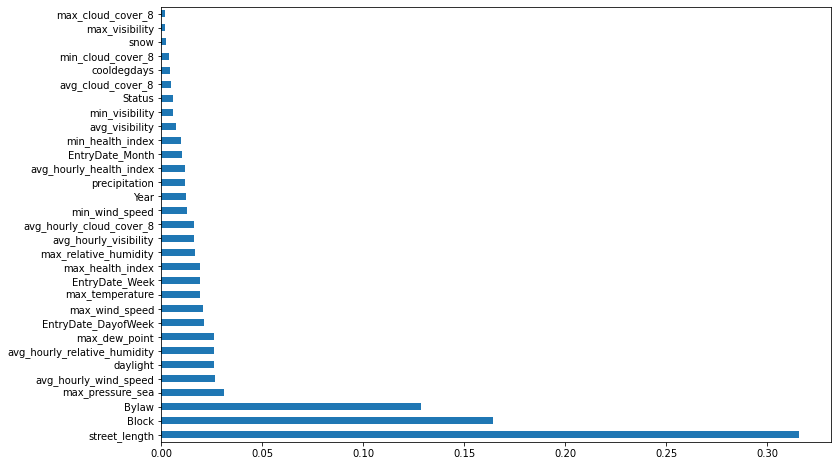

In [141]:
feat_importances = pd.Series(gs.best_estimator_.feature_importances_, index=df.columns[:-1])
fig, ax = plt.subplots(figsize=(12, 8))
feat_importances.nlargest(31).plot(kind='barh')
plt.show()

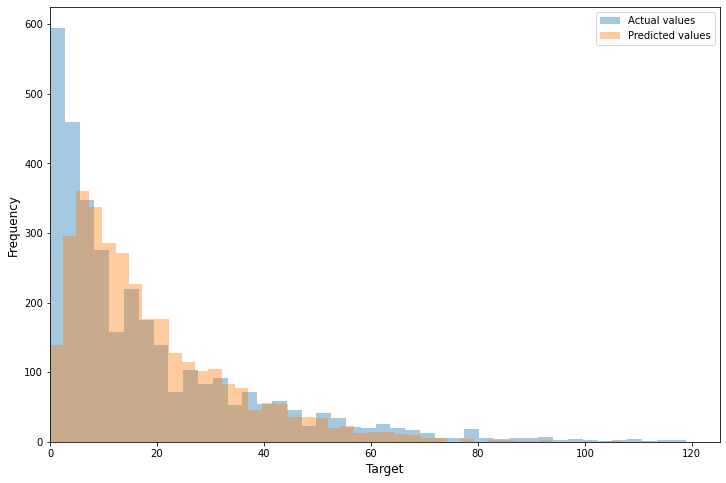

In [273]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.distplot(y_test, hist=True, kde=False)
sns.distplot(y_pred, hist=True, kde=False)
plt.legend(labels=['Actual values', 'Predicted values'])
ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.xlim(0,)
plt.show()

## Conclusions

### Scalability and Impact

To be scalable our proposal needs to be adapted to run in cloud. For this challenge we only selected a single regression algorithm, but this may not be the most suitable for this problem, however due to the size of the data, we only used one sample of the data and one algorithm. 

Our approach may be used to improved the parking regulation rules like pricing and time limitation to help preventing irregular parking.

### Future Work

- Predict in large subsets or in all data
- Repeat the experiment with different regression algorithms
- More hyperparameterisation tunning
- Other approach: instead of regression problem, use classification for [risky tickets](https://www.tandfonline.com/doi/full/10.1080/19475683.2019.1679882) (probability of getting tickets)
- Add fire hydrants information to improve the caracterisation of data
